In [8]:
import pandas as pd 
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef
)
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

#from autogluon.tabular import TabularPredictor

In [9]:
# Importer la data
K2 = pd.read_csv('K2.csv')
KOI = pd.read_csv('KOI.csv')
TOI = pd.read_csv('TOI.csv')
K2['transit_dur'] = np.nan

#Transit_depth K2
K2['transit_depth'] = ((K2['pl_rade']*(0.009157))/K2['st_rad'])**2 




In [10]:
# Label
map = {
    "FP" : "FALSE POSITIVE",
    "PC" : "CANDIDATE",
    "KP" : "CONFIRMED",
    "APC" : "CANDIDATE",
    "FA" : "FALSE POSITIVE",
    "CP" : "CONFIRMED"
}
TOI["tfopwg_disp"] = TOI["tfopwg_disp"].replace(map)


def colonne(name1, name2, name3):
    merged = pd.concat([TOI[name1], KOI[name2], K2[name3]], ignore_index = True, axis = 0) 
    df = pd.DataFrame(merged)
    return df 


# On crée nos grandes colonnes
cY = colonne('tfopwg_disp', 'koi_disposition', 'disposition')
cTemp = colonne('pl_eqt', 'koi_teq', 'pl_eqt')
cTransitDepth = colonne('pl_trandep', 'koi_depth', 'transit_depth')
cTransitDur = colonne('pl_trandurh', 'koi_duration', 'transit_dur')
cMagn = colonne('st_tmag', 'koi_kepmag', 'sy_vmag')
cRadius = colonne('pl_rade', 'koi_prad', 'pl_rade')
cOrb = colonne('pl_orbper', 'koi_period', 'pl_orbper')
#cMass = colonne('st_mass', 'koi_mass', 'st_mass')
cRadSt = colonne('st_rad', 'koi_srad', 'st_rad')
cTeff = colonne('st_teff', 'koi_steff', 'st_teff')
cLogg = colonne('st_logg', 'koi_slogg', 'st_logg')
#cInsol = colonne('pl_insol', 'koi_insol', 'pl_insol')
#cDens = colonne('pl_dens', 'koi_dens', 'pl_dens')

 

# On crée notre giga tableau
final_df = pd.concat(
    [
        cY,              # disposition / label
        cTemp,           # température d’équilibre planétaire
        cTransitDepth,   # profondeur du transit
        cTransitDur,     # durée du transit
        cMagn,           # magnitude stellaire
        cRadius,         # rayon planétaire
        cOrb,            # période orbitale
        cRadSt,          # rayon stellaire
        cTeff,           # température stellaire
        cLogg,           # gravité de surface
        # (st_mass retirée car incomplète)
    ],
    axis=1,
    ignore_index=True
)

final_df.columns = [
    'disposition',      # label
    'températureeq',
    'transit_depth',
    'transit_dur',
    'Magnitude',
    'Radius',
    'cOrb',
    'cRadSt',
    'cTeff',
    'cLogg',
]



# Création de nouvelles features physiques dérivées
final_df['ratio_Rp_Rs'] = final_df['Radius'] / (final_df['cRadSt'] + 1e-6)
final_df['log_period'] = np.log1p(final_df['cOrb'])
final_df['depth_dur_ratio'] = final_df['transit_depth'] / (final_df['transit_dur'] + 1e-6)
final_df['ratio_Teff_Eqt'] = final_df['cTeff'] / (final_df['températureeq'] + 1e-6) # pour éviter de diviser par 0 et pout le log


y = final_df.disposition
X = final_df.drop(columns = 'disposition')

# Traiter le Label
map2 = {"REFUTED" : "FALSE POSITIVE"}
y = y.replace(map2)

le = LabelEncoder()
y = le.fit_transform(y)


# On sépare notre data pour ne pas tricher et valider le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

# Traiter les NaN
X_train_plus = X_train.copy()
X_val_plus = X_val.copy()
X_test_plus = X_test.copy()

cwmv = [col for col in X.columns if X[col].isnull().any()]

for col in cwmv:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_val_plus[col + '_was_missing'] = X_val_plus[col].isnull()
    X_test_plus[col + '_was_missing'] = X_test_plus[col].isnull()
    

imput = SimpleImputer()

imp_X_train = pd.DataFrame(imput.fit_transform(X_train_plus))
imp_X_val = pd.DataFrame(imput.transform(X_val_plus))
imp_X_test = pd.DataFrame(imput.transform(X_test_plus))


imp_X_train.columns = X_train_plus.columns
imp_X_val.columns = X_val_plus.columns
imp_X_test.columns = X_test_plus.columns


X_train = imp_X_train
X_val = imp_X_val
X_test = imp_X_test

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')


# StandardScaler car des valeurs sont très grandes 


<Axes: >

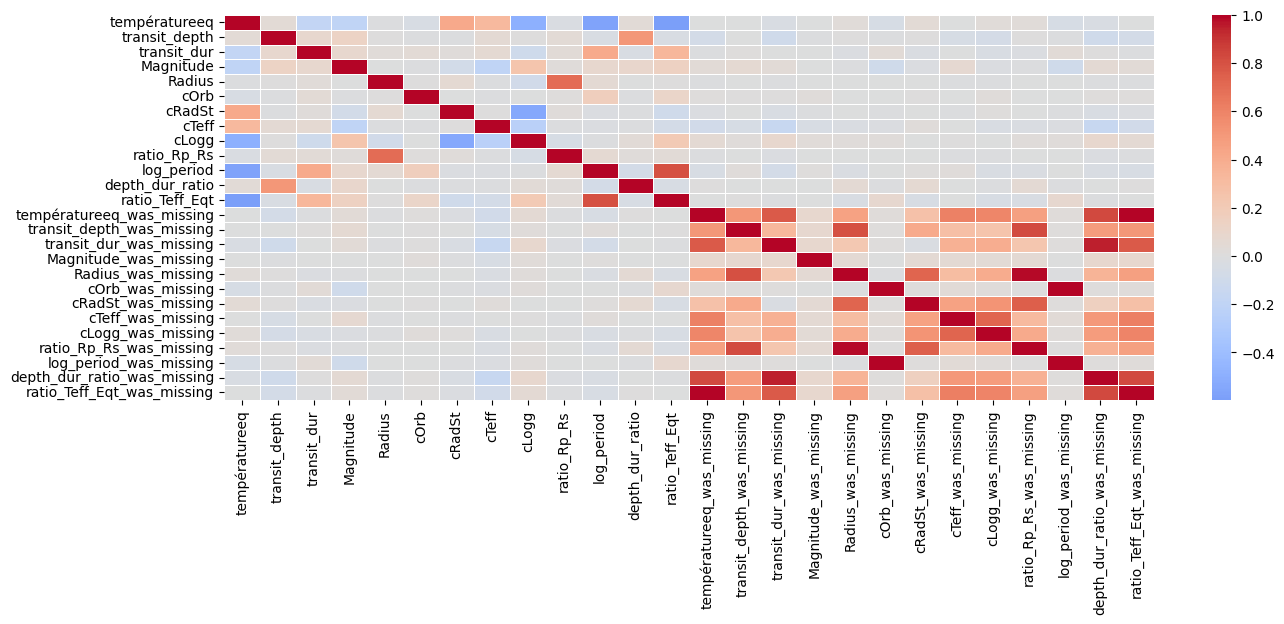

In [11]:
# Matrice de confusion pour voir la corrélation entre les features
import seaborn as sns

corr_matrix = X_train.corr()

plt.figure(figsize =(15,5))
sns.heatmap(
    corr_matrix,
    annot = False,
    cmap = 'coolwarm',
    center = 0,
    linewidths = 0.5
)


 1st base Model

In [20]:
# Construction de la "recette" pour que KerasClassifier la suivent

def build_nn(input_shape):
    model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(3, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

# EarlyStopping
es = EarlyStopping(
    min_delta=0.01,
    patience=20,
    restore_best_weights=True
)

# Wrapper scikit-learn pour stacking
from scikeras.wrappers import KerasClassifier

model_nn = KerasClassifier(
    model=build_nn,
    model__input_shape=([X_train.shape[1]]), 
    batch_size=128,
    epochs=100,
    callbacks=[es]
)

nn = KerasClassifier(
    model=build_nn,
    model__input_shape=([X_train.shape[1]]),
    batch_size=128,
    epochs=50,
)

# Entraînement
h = model_nn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val)
)


Epoch 1/100


c:\Users\alexa\OneDrive\Desktop\proj\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5071 - loss: 0.9925 - val_accuracy: 0.3393 - val_loss: 1.2568
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5795 - loss: 0.8919 - val_accuracy: 0.4944 - val_loss: 0.9431
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6022 - loss: 0.8561 - val_accuracy: 0.5912 - val_loss: 0.8508
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6140 - loss: 0.8368 - val_accuracy: 0.6249 - val_loss: 0.8250
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6236 - loss: 0.8231 - val_accuracy: 0.6272 - val_loss: 0.8132
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6275 - loss: 0.8127 - val_accuracy: 0.6268 - val_loss: 0.8078
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6310 - loss: 0.8063 - val_accuracy: 0.6296 - val_loss: 0.8009
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6346 - loss: 0.7986 - val_accuracy: 0.6331 - val_loss: 0.7

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy : 0.6574
Precision: 0.6707
Recall   : 0.6574
F1-score : 0.6583
Matt score :  0.4821

Rapport complet :
                precision    recall  f1-score   support

     CANDIDATE       0.60      0.71      0.65      1978
     CONFIRMED       0.65      0.65      0.65      1559
FALSE POSITIVE       0.78      0.59      0.68      1568

      accuracy                           0.66      5105
     macro avg       0.68      0.65      0.66      5105
  weighted avg       0.67      0.66      0.66      5105



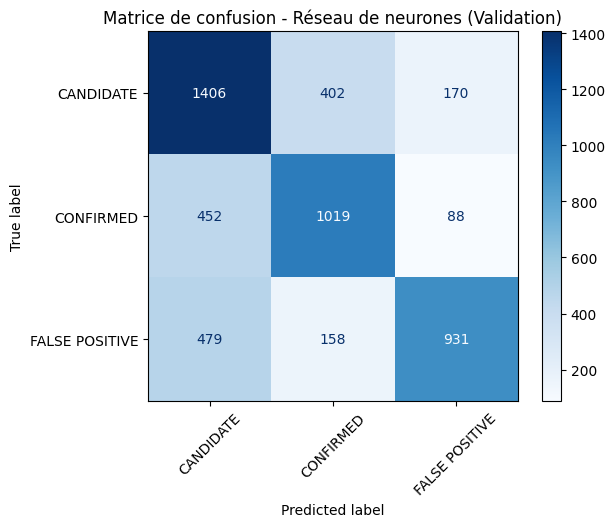

In [21]:
# ----- Évaluation du modèle -----

# On prédit les classes sur le jeu de validation
y_pred = model_nn.predict(X_val)

# 1️ Accuracy = pourcentage de bonnes prédictions
# -> utile pour avoir une vue globale de la performance
acc = accuracy_score(y_val, y_pred)

# 2️ Precision = parmi les prédictions positives, combien sont correctes
# -> "fiabilité" du modèle quand il dit qu’un échantillon est d’une classe donnée
prec = precision_score(y_val, y_pred, average='weighted')

# 3️ Recall = parmi les vraies occurrences positives, combien ont été trouvées
# -> "sensibilité" du modèle, important pour ne pas rater des exoplanètes réelles
rec = recall_score(y_val, y_pred, average='weighted')

# 4️ F1-score = moyenne harmonique entre précision et recall
# -> équilibre entre ne pas rater (recall) et ne pas se tromper (precision)
f1 = f1_score(y_val, y_pred, average='weighted')

mat = matthews_corrcoef(y_val, y_pred)

# On affiche le résumé global
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1-score :", round(f1, 4))
print("Matt score : ", round(mat, 4))

# 5️ Classification report complet (par classe)
# -> très utile pour voir les performances détaillées classe par classe
print("\nRapport complet :")
print(classification_report(y_val, y_pred, target_names=le.classes_))

# 6 Matrice de confusion (visualisation des erreurs)
# -> montre quelles classes sont confondues entre elles
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion - Réseau de neurones (Validation)")
plt.show()




2nd base Model

In [29]:
from sklearn.metrics import accuracy_score, classification_report

model_xgb = XGBClassifier(
    random_state = 1,
    n_estimators = 1000,
    max_depth = 6,
    eval_metric = 'mlogloss',
    objective='multi:softprob',
    num_class=3,
    early_stopping_rounds = 20, 
    learning_rate = 0.05,
    )

model_xgb.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)]
)

best_n = model_xgb.best_iteration

xgb = XGBClassifier(
    random_state = 1,
    n_estimators = best_n,
    max_depth = 6,
    eval_metric = 'mlogloss',
    objective='multi:softprob',
    num_class=3,
    learning_rate = 0.05,
    )


[0]	validation_0-mlogloss:1.07432
[1]	validation_0-mlogloss:1.05146
[2]	validation_0-mlogloss:1.03061
[3]	validation_0-mlogloss:1.01135
[4]	validation_0-mlogloss:0.99357
[5]	validation_0-mlogloss:0.97708
[6]	validation_0-mlogloss:0.96146
[7]	validation_0-mlogloss:0.94693
[8]	validation_0-mlogloss:0.93326
[9]	validation_0-mlogloss:0.92032
[10]	validation_0-mlogloss:0.90826
[11]	validation_0-mlogloss:0.89692
[12]	validation_0-mlogloss:0.88600
[13]	validation_0-mlogloss:0.87591
[14]	validation_0-mlogloss:0.86574
[15]	validation_0-mlogloss:0.85651
[16]	validation_0-mlogloss:0.84768
[17]	validation_0-mlogloss:0.83928
[18]	validation_0-mlogloss:0.83154
[19]	validation_0-mlogloss:0.82406
[20]	validation_0-mlogloss:0.81728
[21]	validation_0-mlogloss:0.81092
[22]	validation_0-mlogloss:0.80386
[23]	validation_0-mlogloss:0.79730
[24]	validation_0-mlogloss:0.79110
[25]	validation_0-mlogloss:0.78524
[26]	validation_0-mlogloss:0.77953
[27]	validation_0-mlogloss:0.77430
[28]	validation_0-mlogloss:0.7

In [30]:
# On test le model_xgb
y_pred2 = model_xgb.predict(X_val)

# On évalue les metrics

# 1 Accuracy :
accuracy = accuracy_score(y_val, y_pred2) # deja une moyenne

# 2 Precision :
precision = precision_score(y_val, y_pred2, average = 'weighted') # moyenne par classe , d'ou le average pour moyenner le tout

# 3 recall :
recall = recall_score(y_val, y_pred2, average = 'weighted')

# F1 score : 
f1 = f1_score(y_val, y_pred2, average = 'weighted')



# On affiche le résumé global
print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1-score :", round(f1, 4))



bilan = classification_report(y_val, y_pred2)

# tableau pour visualiser ce qui a été prédit :

results2 = pd.DataFrame({
    "classe réelle" : y_val,
    "classe prédite" : y_pred2
}) 
print(results2)
print(bilan)


Accuracy : 0.7316
Precision: 0.7347
Recall   : 0.7316
F1-score : 0.7322
      classe réelle  classe prédite
0                 2               2
1                 2               0
2                 0               0
3                 0               0
4                 0               0
...             ...             ...
5100              2               2
5101              0               0
5102              2               2
5103              1               1
5104              0               0

[5105 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1978
           1       0.74      0.76      0.75      1559
           2       0.79      0.71      0.75      1568

    accuracy                           0.73      5105
   macro avg       0.74      0.73      0.73      5105
weighted avg       0.73      0.73      0.73      5105



<Axes: >

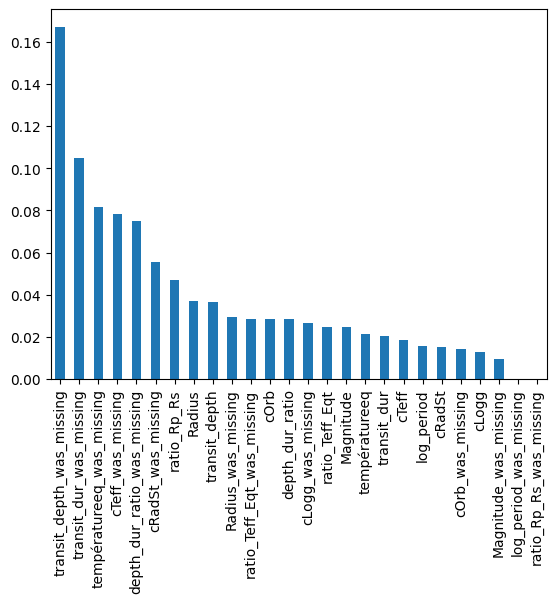

In [ ]:
importance = pd.Series(model_xgb.feature_importances_, index = X_train.columns)
importance.sort_values(ascending = False).plot(kind = 'bar')


3rd Base Model :

In [43]:
from lightgbm import LGBMClassifier, early_stopping

model_lgbm = LGBMClassifier(
    n_estimators = 1000,
    max_depth = 7,
    learning_rate = 0.05,
    objective = "multiclass",
    num_class = 3,
    metric = "multi_logloss",
    random_state =42,
)

model_lgbm.fit(
    X_train, y_train,
    eval_set =[(X_val, y_val)],
    eval_metric ="multi_logloss",
    callbacks=[early_stopping(stopping_rounds=50)]
)


best_n = model_lgbm.best_iteration_

lgbm = LGBMClassifier(
    n_estimators = best_n,
    max_depth = 7,
    learning_rate = 0.05,
    objective = "multiclass",
    num_class = 3,
    metric = "multi_logloss",
    random_state =42,
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3341
[LightGBM] [Info] Number of data points in the train set: 11911, number of used features: 26
[LightGBM] [Info] Start training from score -0.906350
[LightGBM] [Info] Start training from score -1.229568
[LightGBM] [Info] Start training from score -1.192094
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# On test le model_lgbm
y_pred3 = model_lgbm.predict(X_val)

# On évalue les metrics

# 1 Accuracy :
accuracy = accuracy_score(y_val, y_pred3) # deja une moyenne

# 2 Precision :
precision = precision_score(y_val, y_pred3, average = 'weighted') # moyenne par classe , d'ou le average pour moyenner le tout

# 3 recall :
recall = recall_score(y_val, y_pred3, average = 'weighted')

# F1 score : 
f1 = f1_score(y_val, y_pred3, average = 'weighted')



# On affiche le résumé global
print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1-score :", round(f1, 4))



bilan = classification_report(y_val, y_pred3)

# tableau pour visualiser ce qui a été prédit :

results2 = pd.DataFrame({
    "classe réelle" : y_val,
    "classe prédite" : y_pred2
}) 
print(results2)
print(bilan)

Accuracy : 0.7352
Precision: 0.7388
Recall   : 0.7352
F1-score : 0.7358
      classe réelle  classe prédite
0                 2               2
1                 2               0
2                 0               0
3                 0               0
4                 0               0
...             ...             ...
5100              2               2
5101              0               0
5102              2               2
5103              1               1
5104              0               0

[5105 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1978
           1       0.75      0.76      0.76      1559
           2       0.80      0.71      0.75      1568

    accuracy                           0.74      5105
   macro avg       0.74      0.73      0.74      5105
weighted avg       0.74      0.74      0.74      5105



4th base Model :

In [44]:
from sklearn.linear_model import LogisticRegression

# Beoisn de Scaler les valeurs 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)          # calcule moyenne / std sur TRAIN uniquement

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model_lr = LogisticRegression(
    multi_class='multinomial',   # softmax général
    solver='lbfgs',              #  Le solver est l’algorithme qui descend cette fonction de coût pour la minimiser.
    max_iter=1000,               # augmente pour éviter le warning de convergence
    C=2,                       # inverse de la régularisation (plus petit = plus régularisé)
    class_weight='balanced',     # utile si les classes sont un peu déséquilibrées (légerment le cas ici)
    random_state=42
)


model_lr.fit(X_train_scaled, y_train)



c:\Users\alexa\OneDrive\Desktop\proj\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,2
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [ ]:
# On test le model_lgbm
y_pred4 = model_lr.predict(X_val_scaled)

# On évalue les metrics

# 1 Accuracy :
accuracy = accuracy_score(y_val, y_pred4) # deja une moyenne

# 2 Precision :
precision = precision_score(y_val, y_pred4, average = 'weighted') # moyenne par classe , d'ou le average pour moyenner le tout

# 3 recall :
recall = recall_score(y_val, y_pred4, average = 'weighted')

# F1 score : 
f1 = f1_score(y_val, y_pred4, average = 'weighted')



# On affiche le résumé global
print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1-score :", round(f1, 4))



bilan = classification_report(y_val, y_pred4)

# tableau pour visualiser ce qui a été prédit :

results2 = pd.DataFrame({
    "classe réelle" : y_val,
    "classe prédite" : y_pred4
}) 
print(results2)
print(bilan)

Accuracy : 0.6027
Precision: 0.6054
Recall   : 0.6027
F1-score : 0.5958
      classe réelle  classe prédite
0                 2               2
1                 2               0
2                 0               1
3                 0               0
4                 0               0
...             ...             ...
5100              2               2
5101              0               0
5102              2               2
5103              1               1
5104              0               1

[5105 rows x 2 columns]
              precision    recall  f1-score   support

           0       0.59      0.44      0.51      1978
           1       0.57      0.76      0.65      1559
           2       0.65      0.65      0.65      1568

    accuracy                           0.60      5105
   macro avg       0.61      0.62      0.60      5105
weighted avg       0.61      0.60      0.60      5105



On va stacker les 4 modèles suivants :
- XGBClassifier
- Petit modèle de neurone
- LGBMClassifier
- LogisticRegression

Pour ensuite le faire passer à travers un meta modèle (ici Logistic Regression).

In [53]:
from sklearn.ensemble import StackingClassifier

# Base model
base_learners = [
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('NN', nn),
    ('lgr', model_lr)
]

# meta model
meta_model = XGBClassifier()

# Stacking 
stacked_model = StackingClassifier(
    estimators = base_learners,
    final_estimator = meta_model,
    passthrough=True,
    stack_method='predict_proba',
    cv = 5,
    n_jobs = -1
)


stacked_model.fit(X_train, y_train)
y_pred_final = stacked_model.predict(X_test)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Accuracy : 0.7356
Precision: 0.7372
Recall   : 0.7356
F1-score : 0.7358
Matt score :  0.5983

Rapport complet :
                precision    recall  f1-score   support

     CANDIDATE       0.70      0.74      0.72      1704
     CONFIRMED       0.77      0.76      0.77      1286
FALSE POSITIVE       0.76      0.70      0.73      1265

      accuracy                           0.74      4255
     macro avg       0.74      0.73      0.74      4255
  weighted avg       0.74      0.74      0.74      4255



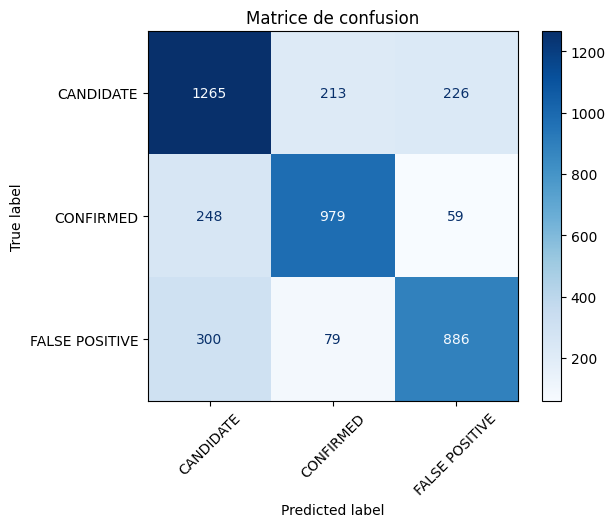

In [54]:
# 1️ Accuracy = pourcentage de bonnes prédictions
# -> utile pour avoir une vue globale de la performance
acc = accuracy_score(y_test, y_pred_final)

# 2️ Precision = parmi les prédictions positives, combien sont correctes
# -> "fiabilité" du modèle quand il dit qu’un échantillon est d’une classe donnée
prec = precision_score(y_test, y_pred_final, average='weighted')

# 3️ Recall = parmi les vraies occurrences positives, combien ont été trouvées
# -> "sensibilité" du modèle, important pour ne pas rater des exoplanètes réelles
rec = recall_score(y_test, y_pred_final, average='weighted')

# 4️ F1-score = moyenne harmonique entre précision et recall
# -> équilibre entre ne pas rater (recall) et ne pas se tromper (precision)
f1 = f1_score(y_test, y_pred_final, average='weighted')

mat = matthews_corrcoef(y_test, y_pred_final)

# On affiche le résumé global
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1-score :", round(f1, 4))
print("Matt score : ", round(mat, 4))

# 5️ Classification report complet (par classe)
# -> très utile pour voir les performances détaillées classe par classe
print("\nRapport complet :")
print(classification_report(y_test, y_pred_final, target_names=le.classes_))

# 6 Matrice de confusion (visualisation des erreurs)
# -> montre quelles classes sont confondues entre elles
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion")
plt.show()
